定义数据解析函数

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
from scipy.stats import spearmanr, pearsonr


def cal_mean_std(transfer_results):
    mean_transfer_results = np.zeros(transfer_results.shape[:2]) # np.zeros_like(transfer_results)
    std_transfer_results = np.zeros(transfer_results.shape[:2]) # np.zeros_like(transfer_results)
    for tgt_idx in range(transfer_results.shape[1]): # square shape
        for src_idx in range(transfer_results.shape[0]):
            mean_transfer_results[src_idx, tgt_idx] = np.mean(transfer_results[src_idx, tgt_idx])
            std_transfer_results[src_idx, tgt_idx] = np.std(transfer_results[src_idx, tgt_idx])
    return mean_transfer_results.astype(np.float32), std_transfer_results.astype(np.float32)


def calcul_transfer_stats(orig_ft_results, transfer_results, tr_rows, tr_cols, ft_inter_dists):
    mean_transfer_results, std_transfer_results = cal_mean_std(transfer_results)

    mean_transfer_results = pd.DataFrame(mean_transfer_results, columns=tr_cols)
    std_transfer_results = pd.DataFrame(std_transfer_results, columns=tr_cols)

    # Performance迁移结果比值
    transfer_ratio = (mean_transfer_results - orig_ft_results) / orig_ft_results * 100 # -> %
    transfer_ratio['row_name'] = tr_rows
    # Performance迁移结果error margin（std ratio）
    transfer_error = std_transfer_results / orig_ft_results * 100
    transfer_error['row_name'] = tr_rows
    
    # inter-cosine距离
    ft_inter_dists['row_name'] = tr_rows

    # 构建迁移stats
    abbr_dict = {'stability': 'ST', 'fluorescence': 'FL', 'remote_homology': "RH", 'secondary_structure': "SS", 'pdbbind': 'PB', 'kinase': 'KI'}

    transfer_stats = pd.DataFrame(columns=['dist', 'ratio', 'error', 'src_tgt'])
    for src_col in transfer_ratio['row_name']:
        tgt_cols = tr_cols.copy()

        inter_dist = ft_inter_dists[ft_inter_dists['row_name']==src_col][tgt_cols].to_numpy(dtype=np.float32).flatten()
        pef_ratio = transfer_ratio[transfer_ratio['row_name']==src_col][tgt_cols].to_numpy().flatten()
        pef_error = transfer_error[transfer_error['row_name']==src_col][tgt_cols].to_numpy().flatten()

        spec_src_stats = pd.DataFrame(columns=['dist', 'ratio', 'src_tgt'])
        spec_src_stats['dist'] = inter_dist
        spec_src_stats['ratio'] = pef_ratio
        spec_src_stats['error'] = pef_error
        spec_src_stats['src_tgt'] = [f'{src_col}→{abbr_dict[tgt_col]}' for tgt_col in tgt_cols] # 缩写

        transfer_stats = pd.concat([transfer_stats, spec_src_stats], axis='rows')

    # 未跑完所有结果，暂时丢弃nan
    # transfer_stats.dropna(axis=0, how='any', subset=['ratio'], inplace=True)

    return transfer_stats

实验结果

In [2]:
# 最终结果，2022/11/24更新，去除RH，选择FL后，进一步选择ST
tr_cols = ['stability', 'fluorescence', 'secondary_structure', 'pdbbind', 'kinase'] # 
# tr_rows = ['MLM+RMD', 'GO+RMD', 'MLM+GO+D', 'RMD']
tr_rows = ['MLM+RMD', 'G+RMD', 'MLM+G+D', 'RMD']
random_results = np.array([[0.690, 0.699, 0.691, 0.705, 0.715],
                            [0.579, 0.600, 0.607, 0.636, 0.584],
                            [0.682, 0.695, 0.689, 0.684, 0.697],
                            [0.535, 0.587, 0.532, 0.545, 0.616],
                            [0.677, 0.669, 0.578, 0.674, 0.636]], dtype=object)
random_results = np.array([np.mean(r).astype(np.float32) for r in random_results])
empirical_results = np.array([
    [[0.772, 0.727, 0.758, 0.777, 0.758], [0.632, 0.686, 0.677, 0.712, 0.634],
     [0.711, 0.731, 0.721, 0.729, 0.730], [0.605, 0.655, 0.606, 0.610, 0.650], [0.681, 0.654, 0.673, 0.689, 0.663]],
    [[0.765, 0.749, 0.727, 0.735, 0.722], [0.558, 0.635, 0.594, 0.643, 0.617],  # ST [0.668, 0.587, 0.631, 0.655, 0.642]
     [0.719, 0.726, 0.719, 0.719, 0.727], [0.607, 0.695, 0.596, 0.599, 0.604], [0.655, 0.653, 0.666, 0.701, 0.674]],
    [[0.761, 0.711, 0.722, 0.720, 0.731], [0.608, 0.609, 0.624, 0.616, 0.627],
     [0.719, 0.729, 0.728, 0.722, 0.728], [0.597, 0.661, 0.596, 0.595, 0.600], [0.666, 0.642, 0.679, 0.679, 0.665]],
    [[0.721, 0.740, 0.738, 0.729, 0.750], [0.566, 0.648, 0.649, 0.614, 0.613],  # ST [0.705√, 0.648, 0.655, 0.676, 0.678]
     [0.774, 0.762, 0.765, 0.763, 0.728], [0.609, 0.665, 0.616, 0.622, 0.630], [0.656, 0.655, 0.673, 0.686, 0.669]]
], dtype=object)
# OTMTD spr: -0.7368421052631579. 

# Transferability vs Perf 线性拟合

### 直接计算相关系数

In [4]:
# 2022/11/11 除RH，含Kinase
otmtd_distances = np.load("./results(sole_otmtd)/otmtd_distance_20bins_500_fix.npy")
bl1_otdd = np.load("./results(all)/bs1_sep_mean_otdd_p2.npy")[:, [0, 1, 3, 4, 5]]
bl2_otnce = np.load("./results(all)/bs3_sep_mean_otnce.npy")[:, [0, 1, 3, 4, 5]]
bl3_xpw = np.load("./results(all)/bs4_sep_mean_XpW.npy")[:, [0, 1, 3, 4, 5]]
bl4_hscore = np.load("./results(final)/bl4_hscore.npy")

tr_cols = ['stability', 'fluorescence', 'secondary_structure', 'pdbbind', 'kinase']
all_measures = [otmtd_distances, bl1_otdd, bl2_otnce, bl3_xpw, bl4_hscore]

all_tf_stats = []
for i, measure_distances in enumerate(all_measures):
    dists_df = pd.DataFrame(measure_distances[:4, :5], columns=tr_cols)
    tf_stats = calcul_transfer_stats(random_results[:5], empirical_results[:4, :5], tr_rows, tr_cols, dists_df)
    all_tf_stats.append(tf_stats)

# titles_ = ['OTMTD', 'OTDD', 'OTNCE', 'Wasserstein Distance', 'H-Score']
titles_ = ['OTMTD', 'OTDD', 'OTCE', 'Wasserstein Distance', 'H-Score']
for i, tf_stats in enumerate(all_tf_stats):
    spr, _ = spearmanr(tf_stats['dist'], tf_stats['ratio'])
    plcc, _ = pearsonr(tf_stats['dist'], tf_stats['ratio'])
    print("{} spr: {}, plcc: {}".format(titles_[i], spr, plcc))


OTMTD spr: -0.7037593984962407, plcc: -0.5791767161908549
OTDD spr: -0.6090225563909774, plcc: -0.5318056892494215
OTCE spr: -0.5819548872180451, plcc: -0.42587266343585445
Wasserstein Distance spr: -0.613533834586466, plcc: -0.5277276036535378
H-Score spr: 0.09452663455435117, plcc: 0.31922834220215396


In [5]:
# 保存Method中OTMTD迁移统计数据
all_tf_stats[0].to_pickle("/home/brian/work/OTMTD/results(all)/method_tf_stats.pkl")

### 拟合曲线

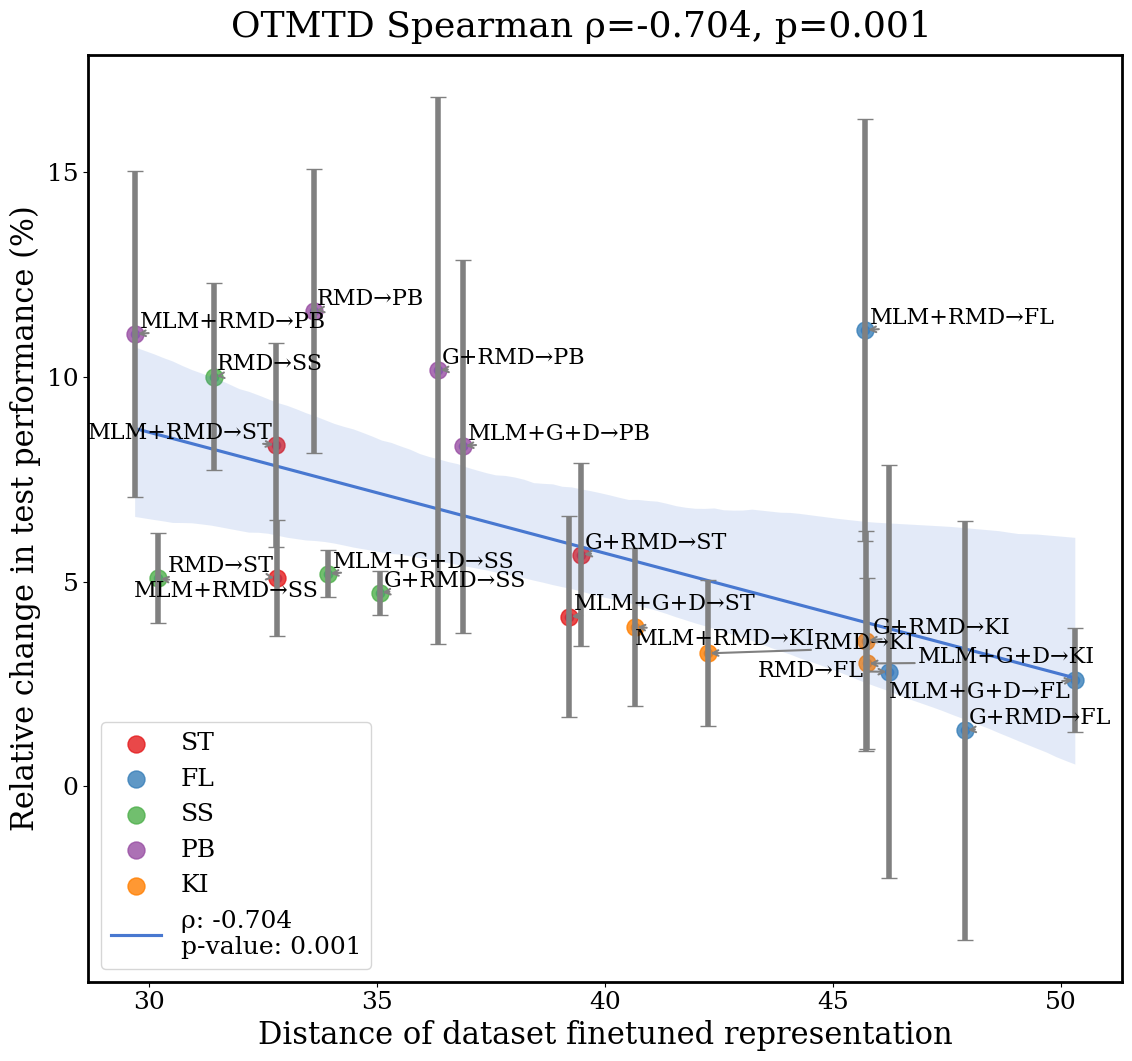

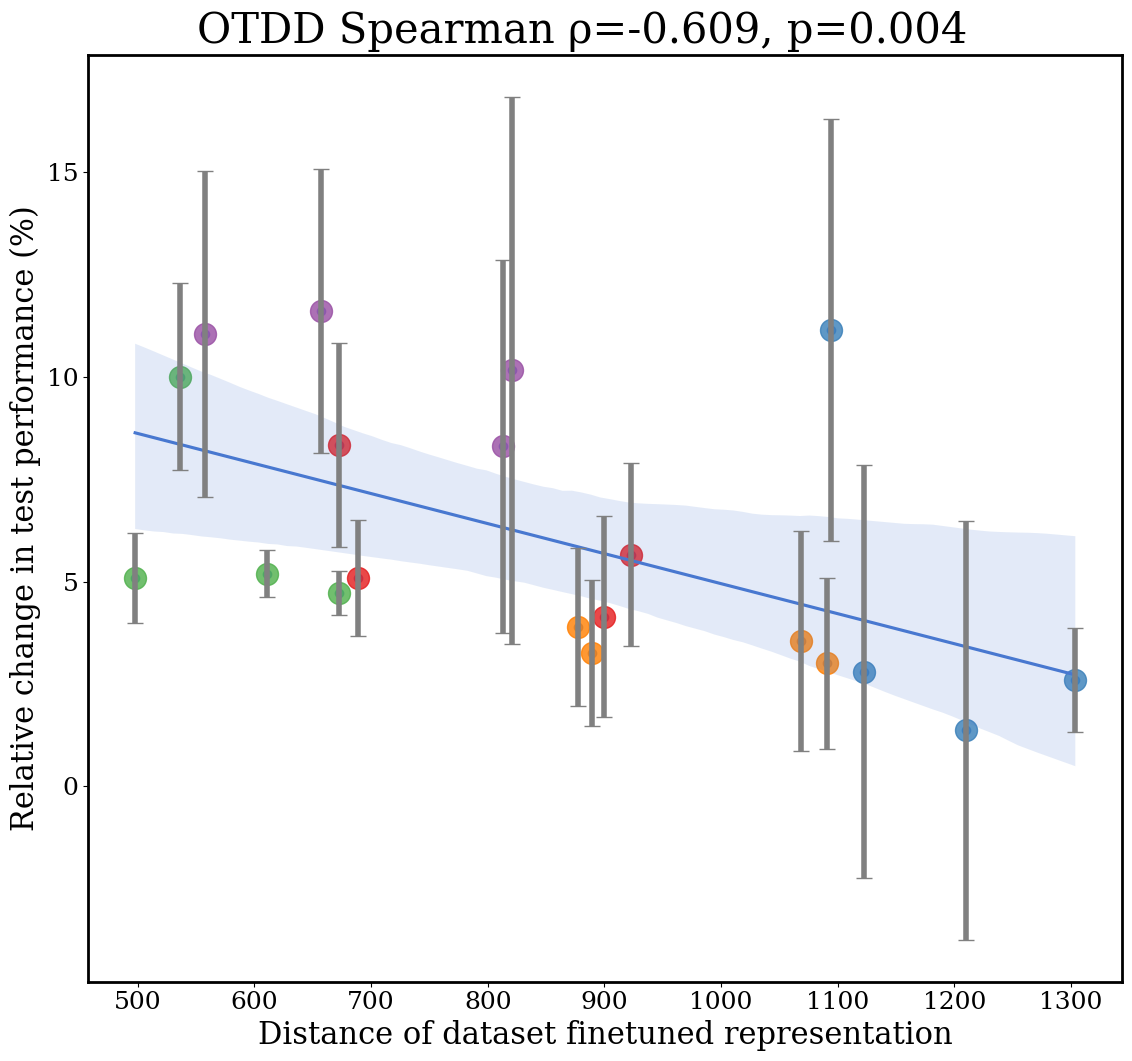

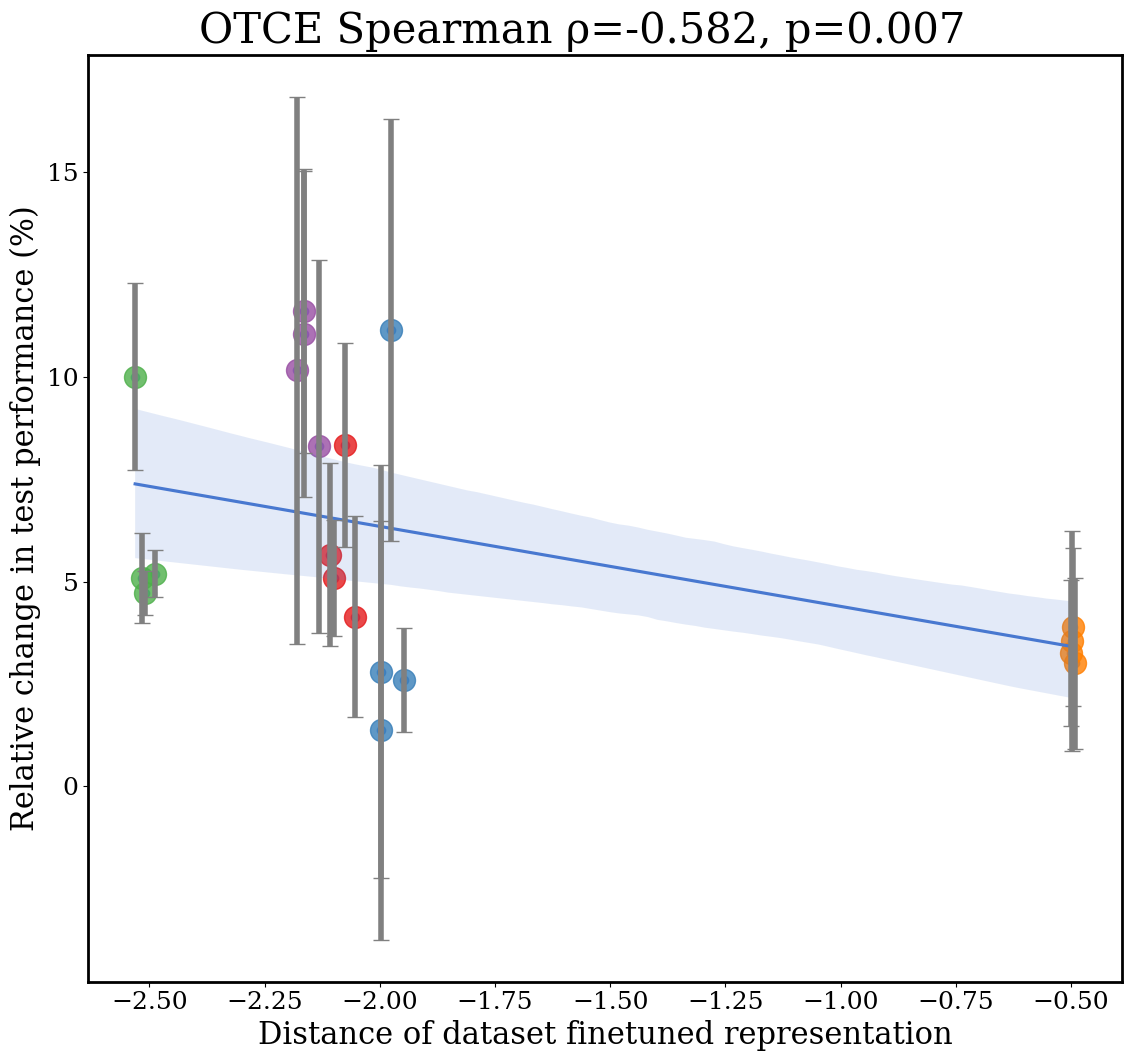

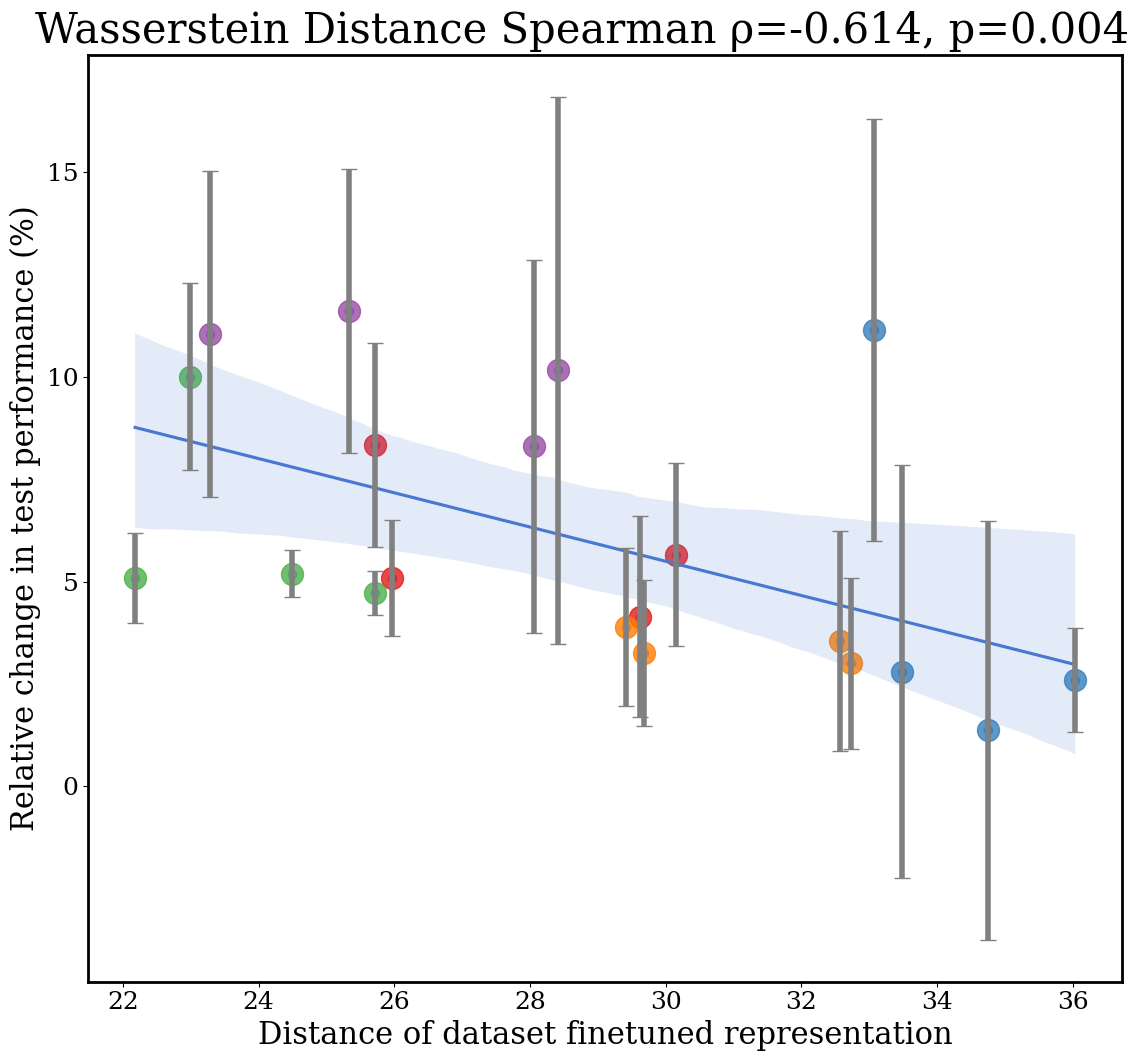

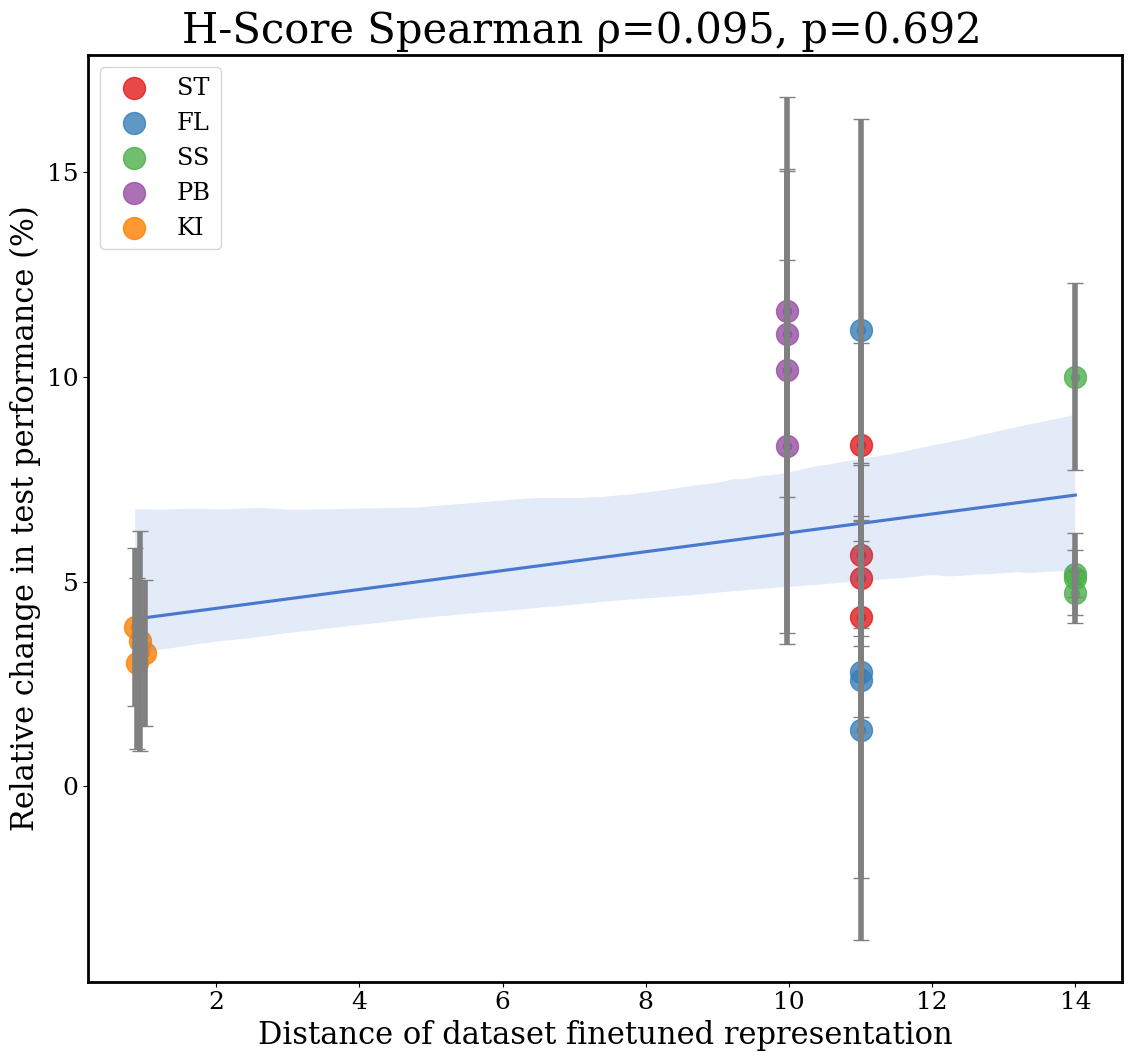

In [5]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['figure.dpi'] = 100
sns.set_palette("muted")
def plotter(transfer_stats, title_):
    # Linear regression fitting
    spr, p = spearmanr(transfer_stats['dist'], transfer_stats['ratio'])
    if title_ == 'OTMTD':
        # Scatter plot each points
        fgrid = sns.lmplot(x="dist", y="ratio", data=transfer_stats, height=10, aspect=10/9, fit_reg=False,
                            legend=False, scatter_kws={"s": 150}, hue='tgt', palette='Set1')
        ax = sns.regplot(x="dist", y="ratio", data=transfer_stats, scatter_kws={"zorder":-1},
                        line_kws={'label': 'ρ: {:.3f}\np-value: {:.3f}'.format(spr, p)})
        # Annotate point
        texts = []
        for i, point in transfer_stats.iterrows():
            texts.append(plt.text(point['dist'], point['ratio'], point['src_tgt'], fontdict={'size': 16}))
        adjust_text(texts, arrowprops=dict(arrowstyle="->", color='grey', lw=1.5)) #
    else:
        fgrid = sns.lmplot(x="dist", y="ratio", data=transfer_stats, height=10, aspect=10/9, fit_reg=False,
                            legend=False, scatter_kws={"s": 250}, hue='tgt', palette='Set1')
        if title_ == 'H-Score':
            plt.legend(loc='upper left', prop={'size': 'xx-large'}, ncol=1)
        ax = sns.regplot(x="dist", y="ratio", data=transfer_stats, scatter_kws={"zorder":-1})
    
    # Add error bar
    plt.errorbar(transfer_stats['dist'], transfer_stats['ratio'], yerr=transfer_stats['error'], fmt='', ls='none',
                ecolor='grey', elinewidth=4, capsize=6)
    # Add bbox via spine drawing
    for loc, spine in ax.spines.items(): # spine of left, right, bottom and top
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(2)
    # Label axis and show legend
    ax.set_xlabel("Distance of dataset finetuned representation", size=22)
    ax.set_ylabel("Relative change in test performance (%)", size=22)
    ax.tick_params(axis='both', labelsize=18)

    if title_ == 'OTMTD':
        plt.legend(loc='lower left', prop={'size': 18}, ncol=1)
        plt.suptitle(f"{title_} Spearman ρ={spr:.3f}, p={p:.3f}", size=26, y=1.03)
    else:
        plt.suptitle(f"{title_} Spearman ρ={spr:.3f}, p={p:.3f}", size=30, y=1.03)

os.makedirs('./paper_figs/fitting_curves', exist_ok=True)
for i, tf_stats in enumerate(all_tf_stats):
    tf_stats['tgt'] = tf_stats['src_tgt'].map(lambda x: x.split('→')[-1])
    plotter(tf_stats, titles_[i])
    plt.savefig('./paper_figs/fitting_curves/{}_tf_vs_perf.jpg'.format(titles_[i]), dpi=1024, bbox_inches='tight')

##### baseline与propose曲线合并

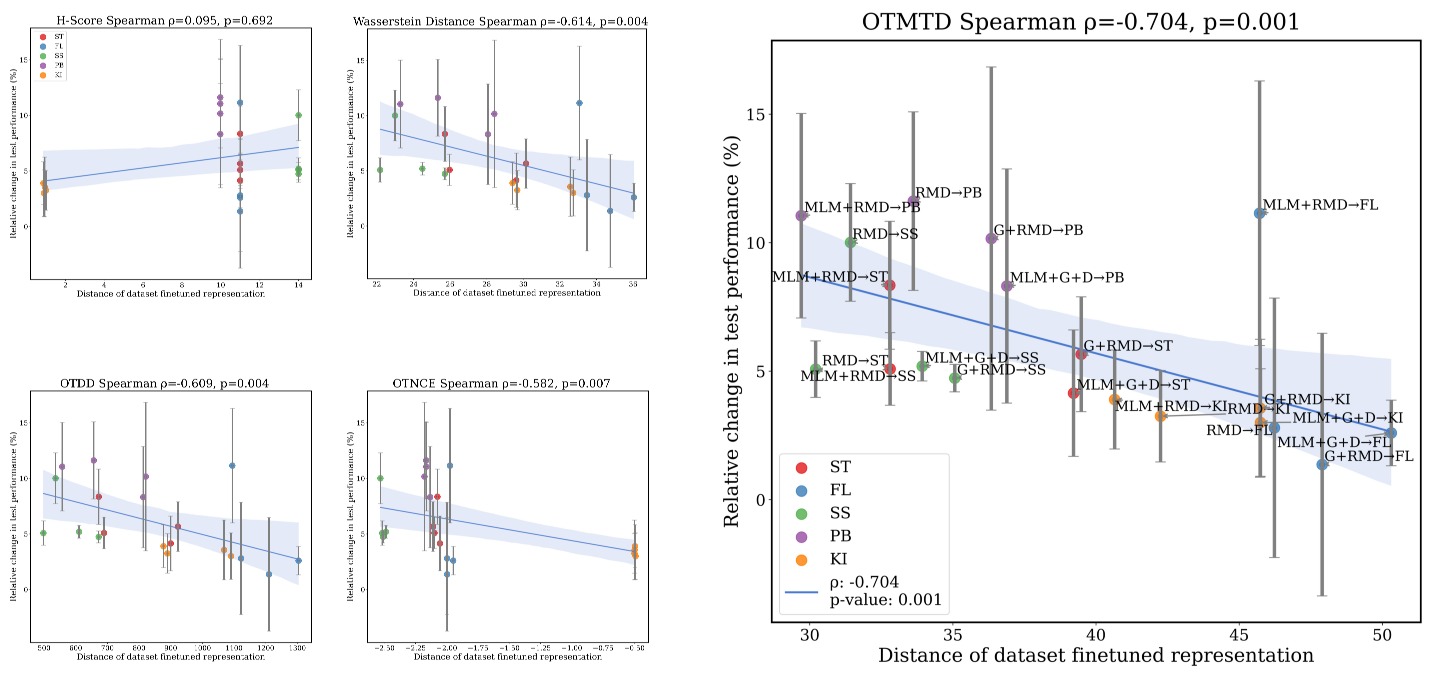

In [42]:
from matplotlib import gridspec

# load images
im_hscore = plt.imread("./paper_figs/fitting_curves/H-Score_tf_vs_perf.jpg")
im_otdd = plt.imread("./paper_figs/fitting_curves/OTDD_tf_vs_perf.jpg")
im_otnce = plt.imread("./paper_figs/fitting_curves/OTNCE_tf_vs_perf.jpg")
im_xpw = plt.imread("./paper_figs/fitting_curves/Wasserstein Distance_tf_vs_perf.jpg")
im_otmtd = plt.imread("./paper_figs/fitting_curves/OTMTD_tf_vs_perf.jpg")


fig = plt.figure(figsize=(26, 12), dpi=100)
spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1, 1.2], wspace=0.05)
# ax_left = fig.add_subplot(spec[0])
inner_spec = gridspec.GridSpecFromSubplotSpec(ncols=2, nrows=2, width_ratios=[1, 1], height_ratios=[1, 1], wspace=0.1,# hspace=0.1,
                                                subplot_spec=spec[0])
# baselines
ax_l1 = fig.add_subplot(inner_spec[0, 0])
ax_l1.imshow(im_hscore)
ax_l2 = fig.add_subplot(inner_spec[0, 1])
ax_l2.imshow(im_xpw)
ax_l3 = fig.add_subplot(inner_spec[1, 0])
ax_l3.imshow(im_otdd)
ax_l4 = fig.add_subplot(inner_spec[1, 1])
ax_l4.imshow(im_otnce)
# propose metric
ax_right = fig.add_subplot(spec[1])
ax_right.imshow(im_otmtd)

def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ## method 1
        # ax.get_xaxis().set_visible(False)
        # ax.get_yaxis().set_visible(False)
        # for loc, spine in ax.spines.items():
        #     spine.set_visible(False)
        ## method 2
        ax.axis('off')
format_axes(fig)
plt.savefig('./paper_figs/fitting_curves/tf_vs_perf.jpg', dpi=1024, bbox_inches='tight')